## Подключение по API к данным о котировках акций Tesla (и конкурентов), создание БД и загрузка полученных данных в БД

ALTER USER postgres WITH PASSWORD 'anna.AZ.baku1'; 

In [6]:
pip install requests pandas sqlalchemy psycopg2

Note: you may need to restart the kernel to use updated packages.


In [7]:
import requests
import pandas as pd

API_KEY = "SQ7DVW4XC2ADFDCC"
symbol = "TSLA"  # Tesla
url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={API_KEY}&outputsize=full"

response = requests.get(url)
data = response.json()["Time Series (Daily)"]

# Преобразуем в DataFrame
df = pd.DataFrame.from_dict(data, orient="index")
df.reset_index(inplace=True)
df.columns = ["date", "open", "high", "low", "close", "volume"]

# Преобразуем типы данных
df["date"] = pd.to_datetime(df["date"]).dt.date
df[["open", "high", "low", "close"]] = df[["open", "high", "low", "close"]].astype(float)
df["volume"] = df["volume"].astype(int)


print(f"Загружено записей: {len(df)}")  # Проверяем, сколько данных получили
print(df.head(10))

Загружено записей: 3783
         date    open      high       low   close     volume
0  2025-07-14  317.73  322.5986  312.6700  316.90   78043430
1  2025-07-11  307.89  314.0900  305.6500  313.51   79236442
2  2025-07-10  300.05  310.4800  300.0000  309.87  104365271
3  2025-07-09  297.55  300.1500  293.5500  295.88   75586771
4  2025-07-08  297.00  304.0499  294.3500  297.81  103246742
5  2025-07-07  291.37  296.1500  288.7701  293.94  131177949
6  2025-07-03  317.99  318.4500  312.7600  315.35   58042302
7  2025-07-02  312.63  316.8320  303.8200  315.65  119483730
8  2025-07-01  298.46  305.8900  293.2100  300.71  145085665
9  2025-06-30  319.90  325.5799  316.6000  317.66   76695081


In [8]:
pip install psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


In [10]:
import psycopg2

#  Подключаемся к БД
conn = psycopg2.connect(
    dbname="my_test_db",
    user="postgres",
    password="anna.AZ.baku1",
    host="localhost",
    port="5432"
)
cursor = conn.cursor()

#  Сбрасываем сломанную транзакцию
conn.rollback()

# Проверяем и приводим к нужным типам данных
df["date"] = pd.to_datetime(df["date"]).dt.date  # Дата в формате DATE
df["open"] = df["open"].astype(float)
df["high"] = df["high"].astype(float)
df["low"] = df["low"].astype(float)
df["close"] = df["close"].astype(float)
df["volume"] = df["volume"].astype(int)


# SQL-запрос для вставки данных
insert_query = """
INSERT INTO stock_quotes_tesla (date, open, high, low, close, volume)
VALUES (%s, %s, %s, %s, %s, %s)
ON CONFLICT (date) DO NOTHING;
"""

# Преобразуем df в список кортежей
data_to_insert = df[["date", "open", "high", "low", "close", "volume"]].values.tolist()

# Вставляем данные с отладкой
for row in data_to_insert:
    try:
        cursor.execute(insert_query, row)
    except Exception as e:
        print(f"❌ Ошибка при вставке строки {row}: {e}")
        conn.rollback()  # Сбрасываем сломанную транзакцию

# Фиксируем изменения и закрываем соединение
conn.commit()
cursor.close()
conn.close()

print("✅ Данные успешно загружены в PostgreSQL!")


✅ Данные успешно загружены в PostgreSQL!


In [11]:
# Подключение к API Alpha Vantage для извлечения данных о котировках Rivian

API_KEY = "SQ7DVW4XC2ADFDCC"
symbol = "RIVN"  # Rivian
url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={API_KEY}&outputsize=full"

response = requests.get(url)
data = response.json()["Time Series (Daily)"]

# Преобразуем в DataFrame
df_rivian = pd.DataFrame.from_dict(data, orient="index")
df_rivian.reset_index(inplace=True)
df_rivian.columns = ["date", "open", "high", "low", "close", "volume"]

# Преобразуем типы данных
df_rivian["date"] = pd.to_datetime(df_rivian["date"]).dt.date
df_rivian[["open", "high", "low", "close"]] = df_rivian[["open", "high", "low", "close"]].astype(float)
df_rivian["volume"] = df_rivian["volume"].astype(int)

In [12]:
# Подключаемся к PostgreSQL
conn = psycopg2.connect(
    dbname="my_test_db",
    user="postgres",
    password="anna.AZ.baku1",
    host="localhost",
    port="5432"
)
cursor = conn.cursor()

# SQL-запрос для вставки данных
insert_query = """
INSERT INTO stock_quotes_rivian (date, open, high, low, close, volume)
VALUES (%s, %s, %s, %s, %s, %s)
ON CONFLICT (date) DO NOTHING;
"""

data_to_insert = df_rivian.values.tolist()
cursor.executemany(insert_query, data_to_insert)

# Фиксируем изменения и закрываем соединение
conn.commit()
cursor.close()
conn.close()

print("✅ Данные по Rivian загружены в PostgreSQL!")


✅ Данные по Rivian загружены в PostgreSQL!


### Расчет волатильности Tesla

In [16]:
#df.dtypes

In [13]:
# df.sort_values(by = 'date', ascending = False)
copy_df = df.copy()

copy_df['close'] = pd.to_numeric(copy_df['close'], errors='coerce')
copy_df['prev_close'] = copy_df['close'].shift(1)


In [14]:
copy_df['price_diff_%'] = (copy_df['prev_close'] - copy_df['close'])*100/copy_df['prev_close']

In [15]:
copy_df['volatility'] = copy_df['price_diff_%'].rolling(window=30).std()

copy_df.head(40)

,date,open,high,low,close,volume,prev_close,price_diff_%,volatility
0,2025-07-14,317.730,322.5986,312.6700,316.90,78043430,NaN,NaN,NaN
1,2025-07-11,307.890,314.0900,305.6500,313.51,79236442,316.90,1.069738,NaN
2,2025-07-10,300.050,310.4800,300.0000,309.87,104365271,313.51,1.161047,NaN
3,2025-07-09,297.550,300.1500,293.5500,295.88,75586771,309.87,4.514797,NaN
4,2025-07-08,297.000,304.0499,294.3500,297.81,103246742,295.88,-0.652291,NaN
5,2025-07-07,291.370,296.1500,288.7701,293.94,131177949,297.81,1.299486,NaN
6,2025-07-03,317.990,318.4500,312.7600,315.35,58042302,293.94,-7.283799,NaN
7,2025-07-02,312.630,316.8320,303.8200,315.65,119483730,315.35,-0.095132,NaN
8,2025-07-01,298.460,305.8900,293.2100,300.71,145085665,315.65,4.733090,NaN
9,2025-06-30,319.900,325.5799,316.6000,317.66,76695081,300.71,-5.636660,NaN


In [16]:
print(copy_df.dtypes)
print(copy_df['volatility'].head())
print(copy_df['volatility'].apply(type).unique())


date             object
open            float64
high            float64
low             float64
close           float64
volume            int32
prev_close      float64
price_diff_%    float64
volatility      float64
dtype: object
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: volatility, dtype: float64
[<class 'float'>]


In [17]:
print(copy_df.shape)
print(copy_df.columns)


(3783, 9)
Index(['date', 'open', 'high', 'low', 'close', 'volume', 'prev_close',
       'price_diff_%', 'volatility'],
      dtype='object')


C:\Users\Ann\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Ann\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


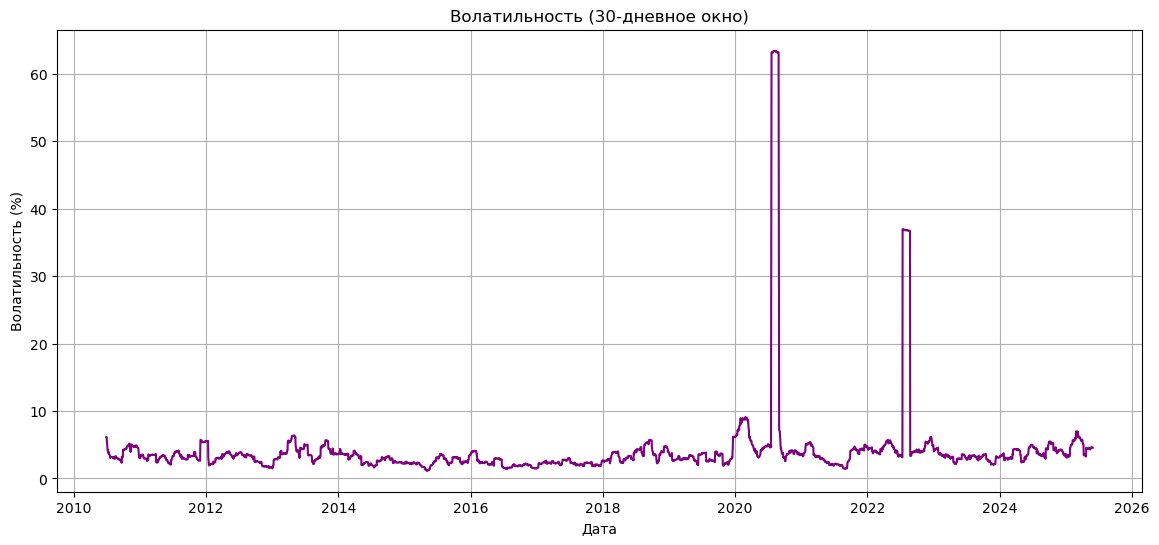

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.lineplot(data=copy_df, x='date', y='volatility', color='purple')
plt.title('Волатильность (30-дневное окно)')
plt.xlabel('Дата')
plt.ylabel('Волатильность (%)')
plt.grid(True)
plt.show()